***
# <font color=green size=10>Lista 2: Inferência estatística via simulação</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
from scipy.stats import poisson
from scipy.optimize import minimize

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**Definindo constantes globais.**

In [2]:
# Valor da semente padrão
SEED = 42

**Montando o dataset da lista.**

In [3]:
# Carrega os arquivos csv originais
climbing_statistics = pd.read_csv("climbing_statistics.csv")
rainier_weather = pd.read_csv("Rainier_Weather.csv")

# Junta os arquivos, elimina linhas e colunas desnecessárias e renomeia colunas
dados_completos = climbing_statistics.merge(rainier_weather, left_on="Date", right_on="Date", how="left")
dados_completos = dados_completos.drop(["Success Percentage", "Battery Voltage AVG"], axis=1)
dados_completos = dados_completos.query("Attempted >= Succeeded")
dados_completos = dados_completos.rename(columns={"Date": "Data", "Succeeded": "Sucessos", "Attempted": "Tentativas",
                              "Temperature AVG": "Temperatura", "Relative Humidity AVG": "Umidade_relativa",
                              "Wind Speed Daily AVG": "Velocidade_vento", "Wind Direction AVG": "Direc_vento",
                              "Solare Radiation AVG": "Radiacao_solar"})

# Aplica as transformações nos dados
dados_completos.Temperatura = (dados_completos.Temperatura - 32) * 5 / 9
dados_completos["Cleaver"] = dados_completos.Route == "Disappointment Cleaver"
dados_completos.Data = pd.to_datetime(dados_completos.Data)

# Reordena as colunas de acordo com o layout definido para a lista
dados_completos = dados_completos.reindex(columns=["Data", "Sucessos", "Route", "Tentativas", "Temperatura", "Umidade_relativa",
                               "Velocidade_vento", "Direc_vento", "Radiacao_solar", "Cleaver"])

___

## Contextualização

"O Monte Rainier é um estratovulcão, e a montanha mais alta do estado norte-americano de Washington.(. . . ) Sua altitude é de 4392m e, em dias de tempo claro, seu pico permanentemente nevado pode ser facilmente avistado de Seattle e outras cidades da região." (*wikipédia*)

Um conjunto de dados sobre tentativas de se escalar o Monte Rainier está disponível no site *Kaggle*, e pode ser obtido pelo link [https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3).

Usaremos Modelos Lineares Generalizados para descrever como o número de montanhistas que alcançam o cume do monte em um dado dia (sucessos) varia em função da temperatura média do ar (em graus Celsius).

A seguir apresentamos a estrutura do banco de dados.

In [4]:
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 0 to 4076
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              4067 non-null   datetime64[ns]
 1   Sucessos          4067 non-null   int64         
 2   Route             4067 non-null   object        
 3   Tentativas        4067 non-null   int64         
 4   Temperatura       1889 non-null   float64       
 5   Umidade_relativa  1889 non-null   float64       
 6   Velocidade_vento  1889 non-null   float64       
 7   Direc_vento       1889 non-null   float64       
 8   Radiacao_solar    1889 non-null   float64       
 9   Cleaver           4067 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 321.7+ KB


Considere o modelo $$Y_{ij} \sim Poisson(\lambda_{ij})\\ \lambda_{ij} = exp(\alpha + \beta t_{i}),$$

onde $Y_{ij}$ representa o número de montanhistas que atingiram o cume pela rota $j$ no dia $i$, $\alpha$ e $\beta$ são parâmetros desconhecidos do modelo e $t_{i}$ indica a temperatura média no dia $i$. Para uma determinada temperatura, o modelo prevê o mesmo valor para todas as rotas. Desconsidere os dados da rota *glacier only - no summit attempt*. Por fim, note que para obter o valor de $y_{ij}$ é preciso somar todos os sucessos registrados no dia $i$ para a rota $j$.

In [5]:
dados = dados_completos.query("Route != 'glacier only - no summit attempt'")

## Questão 1)

### a)

___

Conduza um teste de hipóteses por simulação para avaliar a hipótese nula de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente).


Separando os dois grupos (rota Disappointment Cleaver e demais rotas) e calculando suas médias e quantidades.

In [6]:
# Agrega os dados
cleaver_agg = dados.groupby(["Cleaver"]).agg({"Sucessos": ["mean", "count"]})

# Obtem médias, quantidades e diferença entre as médias
media_sucessos_nao_cleaver = cleaver_agg.iloc[0]["Sucessos"]["mean"]
media_sucessos_cleaver = cleaver_agg.iloc[1]["Sucessos"]["mean"]
quant_cleaver = cleaver_agg.iloc[1]["Sucessos"]["count"]
diferenca_medias_real = abs(media_sucessos_nao_cleaver - media_sucessos_cleaver)

# Imprime os valores
print(cleaver_agg, end="\n\n")
print(f"Valor absoluto da diferença das médias: {diferenca_medias_real:0.4f}")

         Sucessos      
             mean count
Cleaver                
False    2.082748  1281
True     3.031618  2720

Valor absoluto da diferença das médias: 0.9489


Executando as simulações e obtendo as médias e diferenças a partir 10.000 amostras aleatórias.

In [7]:
# Roda simulação com 10.000 amostras embaralhadas aleatoriamente
diferencas_medias_amostras = []
for i in range(10000):
    lista_sucessos = dados.Sucessos.sample(dados.shape[0])
    media_cleaver = np.mean(lista_sucessos[:int(quant_cleaver)])
    media_nao_cleaver = np.mean(lista_sucessos[int(quant_cleaver):])
    diferencas_medias_amostras.append(abs(media_cleaver - media_nao_cleaver))

# Imprime os valores
print(f"Maior diferença das médias encontrada: {max(diferencas_medias_amostras):0.4f}")
print(f"Diferença das médias real: {diferenca_medias_real:0.4f}")

Maior diferença das médias encontrada: 0.4245
Diferença das médias real: 0.9489


Exibindo o histograma das diferenças de médias encontradas na simulação.

<AxesSubplot:ylabel='Density'>

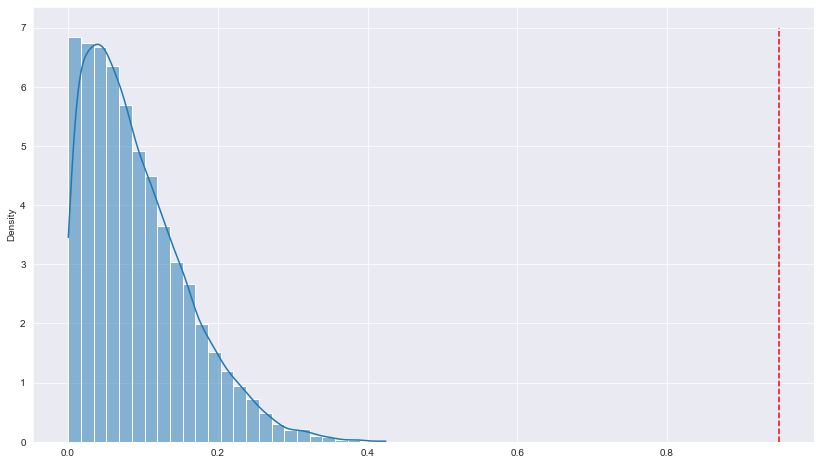

In [8]:
ax = sns.histplot(diferencas_medias_amostras, kde=True, stat="density", bins=25)
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferenca_medias_real, ymin=0, ymax=7, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

A partir do resultado do teste de hipótese por simulação, analisando-se as diferenças absolutas das médias dos dados sintéticos em relação à observada, conclui-se que a hipótese nula ($H_{0}$) de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual à média das demais rotas (conjuntamente) pode ser descartada.

### b)

___

Obtenha o estimador de máxima verossimilhança de $\alpha$ e $\beta$ considerando o modelo proposto. Dica: Use a função $\textsf{optim}$ do $\textbf{\textsf{R}}$ para achar o ponto que maximiza a log-verossimilhança.

Preparando os dados para utilização na função.

In [27]:
# dados_poisson = dados.groupby(["Data", "Temperatura"]).Sucessos.sum()
dados_poisson = dados.query("Temperatura.isnull() != True")
dados_poisson = pd.DataFrame(dados_poisson)
dados_poisson.reset_index(inplace=True)

Definindo e minimizando a função negativa de log-verossimilhança (na prática é a mesma coisa de maximizar a função positiva).

In [30]:
def menos_log_verossimilhanca(parametros):
    alfa, beta = parametros

    lambda_previsto = np.exp(alfa + beta * dados_poisson.Temperatura)
    log_verossimilhanca = np.sum(poisson.logpmf(dados_poisson.Sucessos, lambda_previsto))

    return -1 * log_verossimilhanca

# Minimiza a função negativa de log verossimilhanca
emv = minimize(menos_log_verossimilhanca, np.array([0, 0]))

# Obtem e imprime os valores de alfa e beta
emv_alfa = emv.x[0]
emv_beta = emv.x[1]
print(f"α: {emv_alfa:0.4f}")
print(f"ß: {emv_beta:0.4f}")
print(f"Lamba: {np.exp(emv_alfa + emv_beta * 15)}")

α: 0.8345
ß: 0.0236
Lamba: 3.2813096042654366


Comparando o resultado da maximização da função de log-verossimilhança com os valores de alfa e beta gerados pela biblioteca *statsmodels*.

In [32]:
modelo_poisson = smf.poisson(formula="Sucessos ~ Temperatura", data=dados_poisson)
modelo_poisson_ajustado = modelo_poisson.fit()

print(f"α: {modelo_poisson_ajustado.params[0]:0.4f}")
print(f"ß: {modelo_poisson_ajustado.params[1]:0.4f}")

Optimization terminated successfully.
         Current function value: 3.017568
         Iterations 4
α: 0.8345
ß: 0.0236


<font color='red'>**Resposta:**</font>

Considerando-se o modelo proposto, o estimador de máxima verossimilhança para $\alpha$ é 2,7431 e $\beta$ é 0,1122.

### c)

___

Estime a distribuição de probabilidade do número de sucessos previstos para um dia em que a temperatura seja de 15 graus.

<font color='red'>**Resposta:**</font>

Considerando o valor de $\lambda \cong 83$ para um dia em que a temperatura seja de $15ºC$, o gráfico abaixo ilustra a distribuição de probabilidade do número de sucessos previstos.

In [33]:
amostra = poisson.rvs(mu=np.exp(emv_alfa + emv_beta * 15), size=10000, random_state=SEED)

In [38]:
amostra = pd.Series(amostra, name="Sucessos_previstos")
(amostra.value_counts(normalize=True)*100).sort_index()

0      3.68
1     12.36
2     20.40
3     22.13
4     18.25
5     11.99
6      6.40
7      3.02
8      1.20
9      0.39
10     0.15
11     0.02
12     0.01
Name: Sucessos_previstos, dtype: float64

<AxesSubplot:ylabel='Probability'>

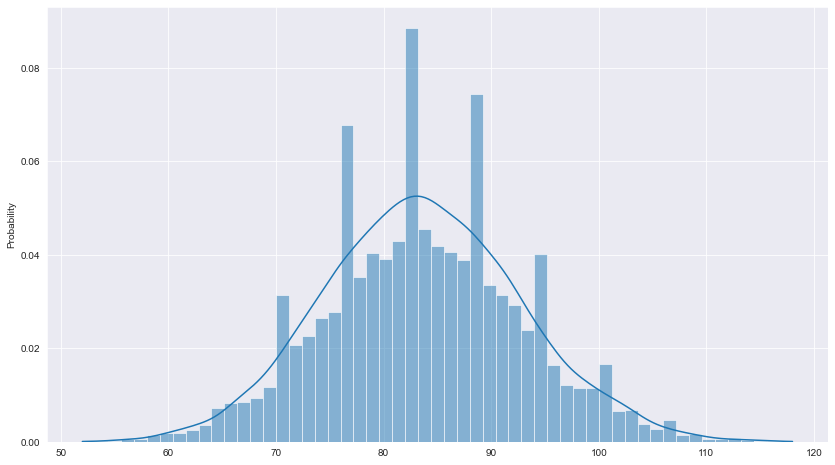

In [12]:
ax = sns.histplot(amostra, kde=True, stat="probability")
ax.figure.set_size_inches(14, 8)
ax

### d)

___

Construa um intervalo de confiança de $95\%$ para $exp(\beta)$ a partir do método de bootstrap paramétrico. Interprete o resultado considerando o contexto dos dados. Dica: calcule o aumento percentual da média esperada quando a temperatura aumenta em $1$ grau Celsius.

Executando o bootstrap paramétrico para o modelo proposto ()

In [13]:
lista_exp_beta = []

X = sm.add_constant(dados_poisson.Temperatura)
for _ in range(10000):
    amostra_sucessos = poisson.rvs(mu=np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura), size=dados_poisson.shape[0])
    modelo_amostra = sm.GLM(amostra_sucessos, X, family=sm.families.Poisson()).fit()

    lista_exp_beta.append(np.exp(modelo_amostra.params[1]))

In [14]:
ic_exp_beta = pd.DataFrame(np.percentile(lista_exp_beta, q=[0.025, 0.975]))
ic_exp_beta = ic_exp_beta.pivot_table(0, columns=ic_exp_beta.index)
ic_exp_beta.columns = ["2.5%", "97.5%"]
ic_exp_beta

,2.5%,97.5%
0,1.108398,1.111501


In [15]:
print(f"exp(ß): {np.exp(emv_beta):0.6f}")

lambda_previsto_t = np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura.iloc[0])
lambda_previsto_t_mais_1 = np.exp(emv_alfa + emv_beta * (dados_poisson.Temperatura.iloc[0] + 1))
print(f"Taxa de crescimento: {lambda_previsto_t_mais_1 / lambda_previsto_t:0.6f}")

exp(ß): 1.118696
Taxa de crescimento: 1.118696


<font color='red'>**Resposta:**</font>

### e)

___

Faça um diagnóstico do modelo via simulação. Para tanto, gere dados sintéticos usando o modelo obtido no item $\textsf{b)}$, ajuste um novo modelo sobre os dados sintéticos e calcule o Erro quadrático médio (MSE). Repita esse procedimento 10000 vezes e compare os MSEs gerados com aquele do modelo obtido em $\textsf{b)}$. Comente os resultados.

In [16]:
dados_poisson["Sucessos_previstos"] = np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura)
dados_poisson["Residuos"] = dados_poisson.Sucessos - dados_poisson.Sucessos_previstos
mse = (dados_poisson.Residuos ** 2).sum() / dados_poisson.shape[0]

print(mse)

603.5770976515278


In [17]:
lista_mse = []
for _ in range(10000):
    amostra_sucessos = poisson.rvs(mu=np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura), size=dados_poisson.shape[0])
    modelo_amostra = sm.GLM(amostra_sucessos, X, family=sm.families.Poisson()).fit()
    residuos = dados_poisson.Sucessos - amostra_sucessos
    mse = np.sum(residuos ** 2) / len(residuos)
    lista_mse.append(mse)

In [18]:
ic_mse = pd.DataFrame(np.percentile(lista_mse, q=[0.025, 0.975]))
ic_mse = ic_mse.pivot_table(0, columns=ic_mse.index)
ic_mse.columns = ["2.5%", "97.5%"]
ic_mse

,2.5%,97.5%
0,565.775287,585.495616


<font color='red'>**Resposta:**</font>

## Questão bônus


Use o método de integração por Monte Carlo para estimar o volume de uma elipsoide definida por $$\frac{x^{2}}{2} + \frac{y^{2}}{3} + \frac{z^{2}}{4} = 1.$$

In [19]:
# Ajusta o tamanho da amostra
tam_amostra = 100000

# Define os denominadores na equação que dão a forma da elipsoide
a = 2
b = 3
c = 4

# Define as coordenadas aleatórias
np.random.seed(SEED)
x = np.random.uniform(-a, a, tam_amostra)
y = np.random.uniform(-b, b, tam_amostra)
z = np.random.uniform(-c, c, tam_amostra)

# Calcula as distâncias das coordenadas segundo a fórmula
distancia = (x / a) ** 2 + (y / b) ** 2 + (z / c) ** 2

# Cria o dataframe com os dados da elipsoide
dados_elipsoide = pd.DataFrame(np.stack((x, y, z, distancia), axis=-1))
dados_elipsoide.columns = ["x", "y", "z", "distancia"]
dados_elipsoide["dentro"] = dados_elipsoide.distancia.apply(lambda distancia: 1 if distancia < 1 else 0)

# Calcula o volume da elipsoide
volume_cubo = 8. * a * b * c
dentro = dados_elipsoide.query("dentro == 1").dentro.count()
proporcao = dentro / tam_amostra
volume = volume_cubo * proporcao

# Imprime o volume estimado pela simulação e o analítico
print("Volume estimado:", volume)
print("Volume analítico:", (4/3) * np.pi * a * b * c)

Volume estimado: 100.60224000000001
Volume analítico: 100.53096491487338


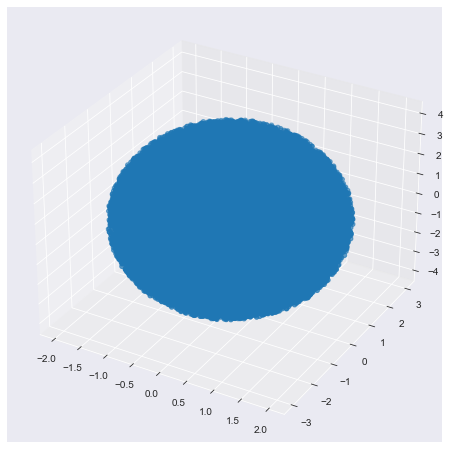

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(14, 8)
dados_scatter = dados_elipsoide.query("dentro == 1")
ax.scatter(dados_scatter.x, dados_scatter.y, dados_scatter.z)
plt.show()

<font color='red'>**Resposta:**</font>